# Assignment II: Discrete Event Simulation

This notebook shows some DES experiments which were needed for assignment II of the course Stoscastic Simulation at the UvA @2021. We start with creating some basis functions, which are used in the experiments afterwards.

In [248]:
import numpy as np
import simpy
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns
from tqdm import trange
from scipy.stats import ttest_ind
import scipy.stats as st

In [264]:
# Based on https://simpy.readthedocs.io/en/latest/examples/carwash.html

class ServerUsage(object):
    def __init__(self, env, num_machines, mu, method):
        self.env = env
        self.mu = mu
        if method == 'FIFO':
            # print("FIFO")
            self.machines = simpy.Resource(env, num_machines)
        elif method == 'prior':
            # print("PRIOR")
            self.machines = simpy.PriorityResource(env, num_machines)

    def service(self, customer):
        yield self.env.timeout(random.expovariate(self.mu))
        # print(f'Customer {customer} has been helped')

    def priorService(self, job_length, customer):
        yield self.env.timeout(job_length)

    def det_service(self, customer):
        yield self.env.timeout(self.mu)

def customer(env, name, Server, deterministic=None):

    global waiting_times

    arrive = env.now
    # print(f'Customer {name} arrives at {arrive}')
    
    with Server.machines.request() as request:
        
        yield request

        # Save waiting times
        waiting_time = env.now - arrive
        waiting_times.append(waiting_time)

        if deterministic is not None:
            yield env.process(Server.det_service(name))
        else:
            yield env.process(Server.service(name))   

        # print(f"Customer {name} leaves service at {env.now}")

def prior_customer(env, name, Server, job_length):

    global waiting_times

    arrive = env.now
    # print(f'Customer {name} arrives at {arrive}')
    
    with Server.machines.request(priority=job_length) as request:
        
        yield request

        # Save waiting times
        waiting_time = env.now - arrive
        waiting_times.append(waiting_time)

        yield env.process(Server.priorService(job_length, name))   

        # print(f"Customer {name} leaves service at {env.now}")


def setup(env, num_machines, rho, mu, number_of_customers, method='FIFO', deterministic=None):

    ServerEnv = ServerUsage(env, num_machines, mu, method)
    lambda_ = rho * (mu * num_machines)

    # i = 0
    # env.process(customer(env, i, ServerEnv))
    # while True:
    #     yield env.timeout(random.expovariate(lambda_))
    #     i += 1
    #     env.process(customer(env, i, ServerEnv))

    if method == 'prior':
        if deterministic is not None:
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))

                job_length = mu
                env.process(prior_customer(env, i, ServerEnv, job_length))

        else:   
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))

                job_length = random.expovariate(ServerEnv.mu)
                env.process(prior_customer(env, i, ServerEnv, job_length))

    elif method == "FIFO":
        if deterministic is not None:
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))

                env.process(customer(env, i, ServerEnv, deterministic))
        else:
            for i in range(number_of_customers):
                yield env.timeout(random.expovariate(lambda_))
                env.process(customer(env, i, ServerEnv))



## 1. Comparison of the multiple server configurations.

All experiments make use of the same configuration. They only differ in the c component, aka the number of servers is changed. 

First we set some global parameters:

Mu is given at 2.5, while Lambda is dependent on c.

In [306]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 500

In [309]:
# Save the data 
data = [[], [], []]
for j in [1, 2, 4]:
    for i in trange(SIMULATIONS):

        waiting_times = []
        service_times = []

        random.seed()
        env = simpy.Environment()
        env.process(setup(env, num_machines=j, rho=RHO, mu=MU, number_of_customers=5000))
        env.run()

        data[0].append(np.mean(waiting_times))
        data[1].append(len(waiting_times))
        data[2].append(j)

data = np.array(data).T
df_boxplot = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers'])


100%|██████████| 500/500 [01:29<00:00,  5.59it/s]


In [210]:
# Save to csv for extra use
df_boxplot.to_csv('../output/boxplot_data.csv')

# Load if needed
df_boxplot = pd.read_csv('../output/boxplot_data.csv')

Text(0.5, 0.98, 'Comparison of waiting times for different number of servers')

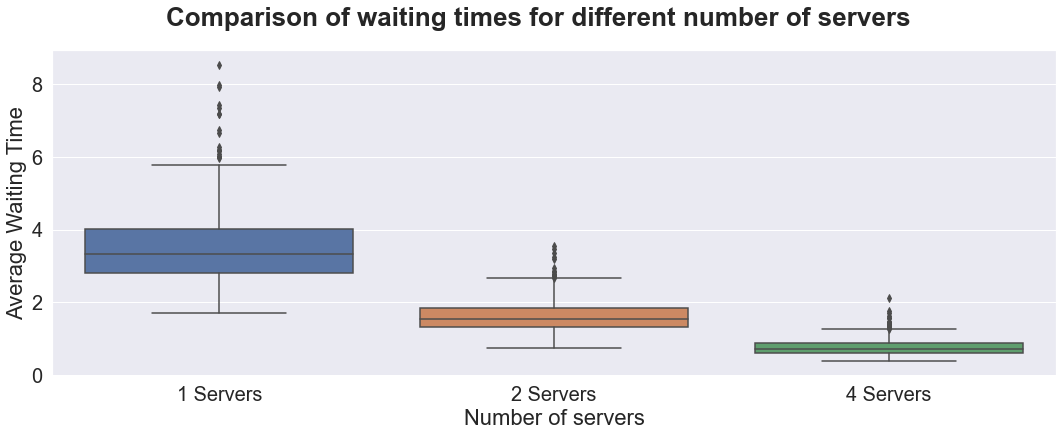

In [211]:
df_boxplot['Servers'] = [f'{int(i)} Servers' for i in df_boxplot['Servers']]

# Draw a boxplot
import seaborn as sns

sns.set(style='darkgrid')

fig, axis = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(x='Servers', y='MeanWaitingTime', data=df_boxplot)
axis.tick_params('both', labelsize=20)
axis.set_xlabel('Number of servers', fontsize=22)
axis.set_ylabel('Average Waiting Time', fontsize=22)
fig.suptitle('Comparison of waiting times for different number of servers', fontsize=26, fontweight='bold')

In [242]:
print("1, 2", ttest_ind(df_boxplot.loc[df_boxplot['Servers'] == '1 Servers']['MeanWaitingTime'], df_boxplot.loc[df_boxplot['Servers'] == '2 Servers']['MeanWaitingTime']))
print("1, 4", ttest_ind(df_boxplot.loc[df_boxplot['Servers'] == '1 Servers']['MeanWaitingTime'], df_boxplot.loc[df_boxplot['Servers'] == '4 Servers']['MeanWaitingTime']))
print("2, 4", ttest_ind(df_boxplot.loc[df_boxplot['Servers'] == '2 Servers']['MeanWaitingTime'], df_boxplot.loc[df_boxplot['Servers'] == '4 Servers']['MeanWaitingTime']))

1, 2 Ttest_indResult(statistic=38.8993095657147, pvalue=3.476303371007822e-202)
1, 4 Ttest_indResult(statistic=60.03058870259847, pvalue=0.0)
2, 4 Ttest_indResult(statistic=39.101897793791835, pvalue=1.516265418780935e-203)


In [251]:


for i in [1, 2, 4]:
    data = df_boxplot.loc[df_boxplot['Servers'] == f'{i} Servers']['MeanWaitingTime'].to_list()
    print(i, "\n Mean: ", np.mean(data))
    print("St.dev: ", np.std(data))
    mi, ma = st.t.interval(alpha=0.95, df=len(data) - 1, scale=st.sem(data))
    print("Conf. int", np.mean(data) + mi, np.mean(data) + ma)


1 
 Mean:  3.542578023021216
St.dev:  1.005981873624443
Conf. int 3.454098530195154 3.6310575158472775
2 
 Mean:  1.6336490923100675
St.dev:  0.4355468679247995
Conf. int 1.5953412788331491 1.6719569057869859
4 
 Mean:  0.7636558924070598
St.dev:  0.2394190248210683
Conf. int 0.7425981830740318 0.7847136017400878


Check how the statistics depend on rho

In [213]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 50

In [214]:
# Save the data 
rhos = np.linspace(0, 1, 101)[1:]
data = [[],[],[],[]]
for z in trange(len(rhos)):
    for j in [1, 2, 4]:
        for i in range(SIMULATIONS):

            waiting_times = []

            random.seed()
            env = simpy.Environment()
            env.process(setup(env, num_machines=j, rho=rhos[z], mu=MU, number_of_customers=500))
            env.run()

            data[0].append(np.mean(waiting_times))
            data[1].append(len(waiting_times))
            data[2].append(j)
            data[3].append(rhos[z])

data = np.array(data).T
df_variance = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers', 'Rho'])

100%|██████████| 100/100 [04:56<00:00,  2.97s/it]


In [215]:
# Save df
df_variance.to_csv('../output/variance_data.csv')

# Read from csv
df_variance = pd.read_csv('../output/variance_data.csv')

In [221]:
sns.set(style='white')

(0.0, 1.0)

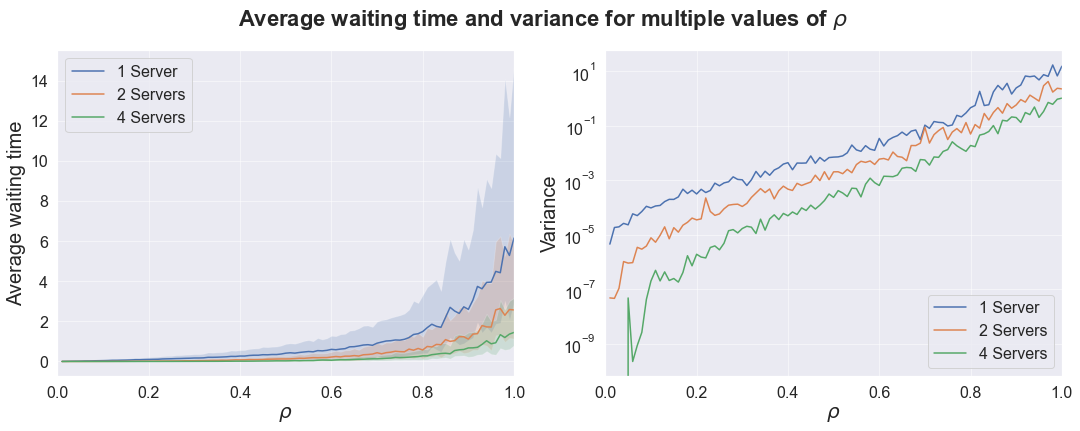

In [252]:
fig, axis = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Average waiting time and variance for multiple values of $\\rho$', fontsize=22, fontweight='bold')
labels = ['1 Server', '2 Servers', '4 Servers']

sub1 = df_variance.loc[df_variance['Servers'] == 1]
sub2 = df_variance.loc[df_variance['Servers'] == 2]
sub4 = df_variance.loc[df_variance['Servers'] == 4]


quantiles = [[[np.quantile(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime'], 0.25),
               np.quantile(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime'], 0.75)] for i in sub1['Rho'].unique()], 
             [[np.quantile(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime'], 0.25),
               np.quantile(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime'], 0.75)] for i in sub1['Rho'].unique()],
             [[np.quantile(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime'], 0.25),
               np.quantile(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime'], 0.75)] for i in sub1['Rho'].unique()]]

means = [[np.mean(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()], 
         [np.mean(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()], 
         [np.mean(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()]]

variances = [[np.var(sub1.loc[sub1['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()],
             [np.var(sub2.loc[sub2['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()],
             [np.var(sub4.loc[sub4['Rho'] == i]['MeanWaitingTime']) for i in sub1['Rho'].unique()]]

# axis[0].scatter(sub1['Rho'], sub1['MeanWaitingTime'])
for i in range(len(quantiles)):
    axis[0].plot(sub1['Rho'].unique(), means[i], label=labels[i])
    axis[0].fill_between(sub1['Rho'].unique(), means[i] - np.array(quantiles[i]).T[0], means[i] + np.array(quantiles[i]).T[1], alpha=0.2)

axis[0].legend(loc='upper left', fontsize=16)
axis[0].tick_params('both', labelsize=16)
axis[0].set_xlabel('$\\rho$', fontsize=20)
axis[0].set_ylabel('Average waiting time', fontsize=20)
axis[0].grid(alpha=0.5)
axis[0].set_xlim(0,1)


for i in range(len(variances)):
    axis[1].plot(sub1['Rho'].unique(), variances[i], label=labels[i])

axis[1].set_yscale('log')
axis[1].set_xlabel('$\\rho$', fontsize=20)
axis[1].set_ylabel('Variance', fontsize=20)
axis[1].tick_params('both', labelsize=16)
axis[1].legend(fontsize=16, loc='lower right')
axis[1].grid(alpha=0.5)
axis[1].set_xlim(0,1)


## 2. Compare results with shortest job first

In [232]:
RHO = 0.9
MU = 2.5
SIMULATIONS = 500

In [233]:
# Save the data 
data = [[], [], [], []]
for z in ['prior', 'FIFO']:
    for j in [1, 2, 4]:
        for i in trange(SIMULATIONS):

            waiting_times = []
            service_times = []

            random.seed()
            env = simpy.Environment()
            env.process(setup(env, num_machines=j, rho=RHO, mu=MU, number_of_customers=5000, method=z))
            env.run()

            data[0].append(np.mean(waiting_times))
            data[1].append(len(waiting_times))
            data[2].append(j)
            data[3].append(z)

data = np.array(data).T
df_comparison = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers', 'Method'])

100%|██████████| 500/500 [01:29<00:00,  5.59it/s]


In [234]:
# Save new dataframe
df_comparison.to_csv('../output/ServiceMethodPrior.csv')

# Load again
df_comparison = pd.read_csv('../output/ServiceMethodPrior.csv')

Text(0.5, 0.98, 'Comparison of waiting times for different number of servers')

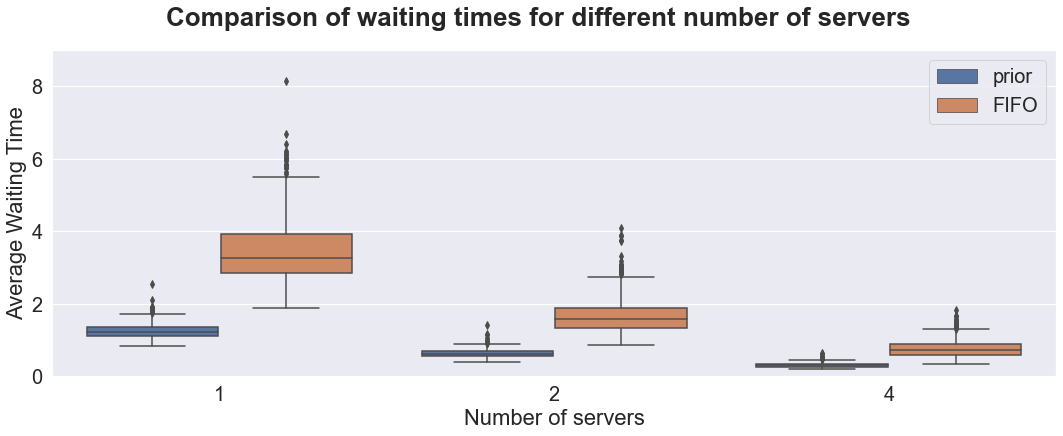

In [241]:
# Draw a boxplot
import seaborn as sns

sns.set(style='darkgrid')

fig, axis = plt.subplots(1, 1, figsize=(18, 6))
sns.boxplot(x='Servers', y='MeanWaitingTime', hue='Method', data=df_comparison)
# sns.boxplot(x='Servers', y='MeanWaitingTime', data=new_df.loc[new_df['Method'] == 'FIFO'])
axis.tick_params('both', labelsize=20)
axis.set_ylim(0, 9)
axis.set_xlabel('Number of servers', fontsize=22)
axis.set_ylabel('Average Waiting Time', fontsize=22)
axis.legend(fontsize=20)
fig.suptitle('Comparison of waiting times for different number of servers', fontsize=26, fontweight='bold')

In [265]:
# Save the data 
data = [[], [], [], []]
for z in [True, None]:
    for j in [1, 2, 4]:
        for i in trange(SIMULATIONS):

            waiting_times = []

            random.seed()
            env = simpy.Environment()
            env.process(setup(env, num_machines=j, rho=RHO, mu=MU, 
                              number_of_customers=5000, method='FIFO', deterministic=z))
            env.run()

            data[0].append(np.mean(waiting_times))
            data[1].append(len(waiting_times))
            data[2].append(j)
            data[3].append(z)

data = np.array(data).T
df_comparisonDeterministic = pd.DataFrame(data, columns=['MeanWaitingTime', 'CustomerCount', 'Servers', 'b_distribution'])

100%|██████████| 500/500 [01:30<00:00,  5.50it/s]


In [266]:
df_comparisonDeterministic.to_csv('../output/ComparisonDeterministic.csv')